In [1]:
pip install laspy[lazrs] geopandas shapely numpy pandas rtree

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 638.7/638.7 kB 13.8 MB/s eta 0:00:0000:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 86.1/86.1 kB 6.2 MB/s eta 0:00:00
Note: you may need to restart the kernel to use updated packages.


Loading /kaggle/input/training-data-labeled/Training_Data_Labeled.laz...
Ground points: 120843704
Grid Size: 1 x 1
Stage 1: Linear Interpolation (CPU)...
       Backfilling linear edges with nearest neighbor...
Stage 3: Anisotropic Diffusion (GPU Convolutions)...
Final DTM Shape: (1, 1)


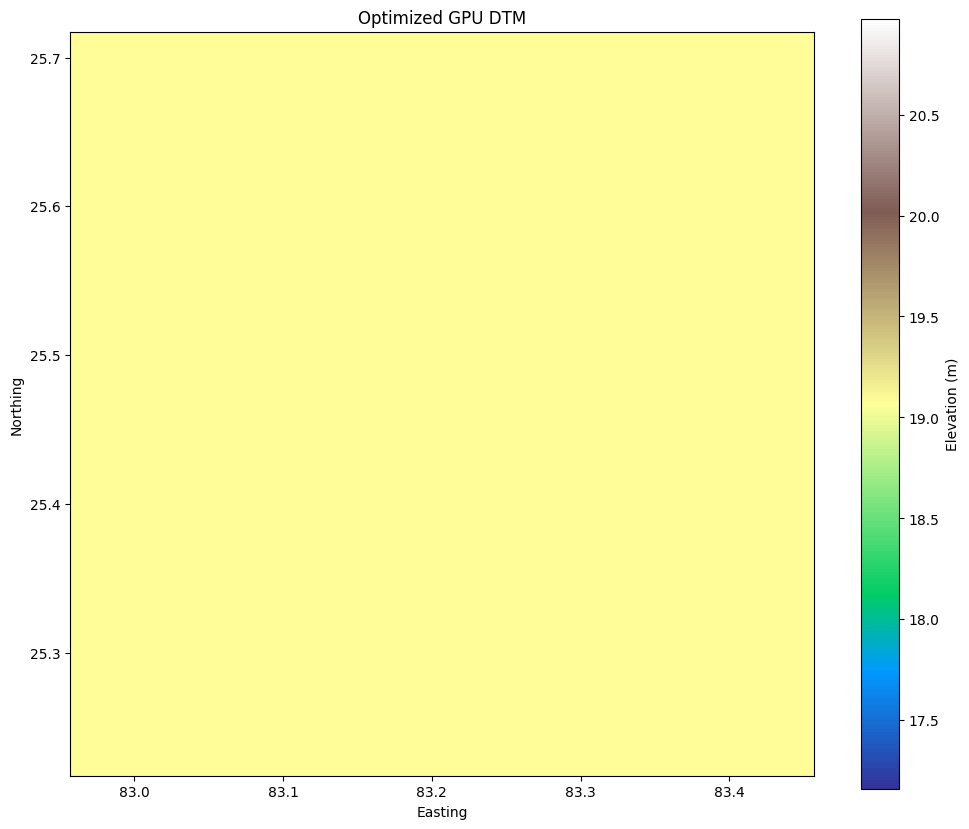

✅ Process Complete.


In [3]:
import numpy as np
import laspy
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
from scipy.interpolate import griddata
from scipy.spatial import cKDTree
import gc

# ================= CONFIG =================
INPUT_FILE = "/kaggle/input/training-data-labeled/Training_Data_Labeled.laz"
GRID_RES = 0.5
K_NEIGHBORS = 8          # Reduced slightly for speed
EDGE_SIGMA = 2.0
DIFFUSION_ITER = 15      # 15-20 is usually sufficient
DIFFUSION_K = 10.0       # Controls edge sensitivity
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# ==========================================

def load_and_filter():
    print(f"Loading {INPUT_FILE}...")
    try:
        las = laspy.read(INPUT_FILE)
    except FileNotFoundError:
        raise FileNotFoundError(f"Could not find file: {INPUT_FILE}")

    # Standardize types to float32 immediately to save RAM
    x = np.array(las.x, dtype=np.float32)
    y = np.array(las.y, dtype=np.float32)
    z = np.array(las.z, dtype=np.float32)
    cls = np.array(las.classification)

    # Filter for Ground (2) and Unclassified (1) if needed, usually Ground is just 2
    # Check your LAS file classes. Assuming 2 is ground.
    ground_mask = (cls == 2) 
    
    # Fallback if no class 2 found
    if ground_mask.sum() == 0:
        print("Warning: No Class 2 (Ground) found. Using Class 1 or all points...")
        ground_mask = (cls == 1)
        
    if ground_mask.sum() == 0:
        raise ValueError("No valid ground points found in LAS file.")

    x_g, y_g, z_g = x[ground_mask], y[ground_mask], z[ground_mask]
    
    # --- CRITICAL FIX: SHIFT COORDINATES ---
    # Large coordinates (UTM) cause precision errors in float32 grid generation
    x_offset, y_offset = x_g.min(), y_g.min()
    x_g -= x_offset
    y_g -= y_offset
    
    print(f"Ground points: {len(x_g)}")
    return x_g, y_g, z_g, x_offset, y_offset

def create_grid(x, y):
    # Determine grid size based on extent and resolution
    width = x.max() - x.min()
    height = y.max() - y.min()
    
    n_w = int(np.ceil(width / GRID_RES))
    n_h = int(np.ceil(height / GRID_RES))
    
    print(f"Grid Size: {n_h} x {n_w}")
    
    # Generate grid coordinates
    xi = np.linspace(x.min(), x.max(), n_w).astype(np.float32)
    yi = np.linspace(y.min(), y.max(), n_h).astype(np.float32)
    
    gx, gy = np.meshgrid(xi, yi, indexing='ij')
    return gx, gy

def edge_aware_interpolation(x, y, z, gx, gy):
    # ---- Stage 1: Linear Interpolation (CPU)
    print("Stage 1: Linear Interpolation (CPU)...")
    dtm = griddata((x, y), z, (gx, gy), method="linear")
    
    # Fill edges that linear interpolation misses (convex hull issues) with nearest
    mask_invalid = np.isnan(dtm)
    if mask_invalid.any():
        print("       Backfilling linear edges with nearest neighbor...")
        dtm_nearest = griddata((x, y), z, (gx, gy), method="nearest")
        dtm[mask_invalid] = dtm_nearest[mask_invalid]
    
    # If any NaNs remain (rare after nearest), fill with mean
    if np.isnan(dtm).any():
        dtm = np.nan_to_num(dtm, nan=np.nanmean(dtm))

    # ---- Stage 2: Batched Edge-aware Smoothing (GPU)
    # Note: We skip the complex IDW tree search here if linear+nearest covered the holes.
    # The diffusion step is usually powerful enough to smooth artifacts.
    
    # ---- Stage 3: Anisotropic diffusion
    print("Stage 3: Anisotropic Diffusion (GPU Convolutions)...")
    dtm = anisotropic_diffusion_gpu(dtm)
    return dtm

def anisotropic_diffusion_gpu(img_np):
    # Prepare Tensor: [Batch, Channel, H, W]
    img = torch.from_numpy(img_np).float().to(DEVICE).unsqueeze(0).unsqueeze(0)
    
    # Laplacian Kernel
    kernel = torch.tensor([[[[0.0, 1.0, 0.0], 
                             [1.0, -4.0, 1.0], 
                             [0.0, 1.0, 0.0]]]], device=DEVICE)

    for i in range(DIFFUSION_ITER):
        # Pad to keep dimensions same
        img_padded = F.pad(img, (1, 1, 1, 1), mode='replicate')
        laplacian = F.conv2d(img_padded, kernel)
        
        # Perona-Malik diffusion coefficient
        # High gradient (edges) -> Low c -> Less smoothing
        c = torch.exp(-(torch.abs(laplacian) / DIFFUSION_K) ** 2)
        
        # Update image
        img = img + 0.15 * (c * laplacian)
        
    # --- CRITICAL FIX: Safe Squeeze ---
    # Original .squeeze() reduced (1,1,H,W) to (H,W), but if H or W was 1, it became scalar.
    # We explicitly select the batch and channel indices.
    return img[0, 0, :, :].cpu().numpy()

def visualize(dtm, x_off, y_off):
    if dtm.size == 0 or dtm.ndim != 2:
        print(f"Error: Invalid DTM shape {dtm.shape}")
        return

    plt.figure(figsize=(12, 10))
    
    # Calculate global extents for axes
    extent = [x_off, x_off + (dtm.shape[1] * GRID_RES), 
              y_off, y_off + (dtm.shape[0] * GRID_RES)]
    
    # Transpose (.T) is often needed because meshgrid 'ij' vs imshow logic
    # We inspect shape to be sure. If gx was (W, H), dtm is (W, H). imshow wants (H, W).
    im = plt.imshow(dtm.T, origin="lower", cmap="terrain", extent=extent)
    
    plt.colorbar(im, label="Elevation (m)")
    plt.title("Optimized GPU DTM")
    plt.xlabel("Easting")
    plt.ylabel("Northing")
    plt.show()

if __name__ == "__main__":
    try:
        # Load and Shift Coordinates
        xg, yg, zg, x_off, y_off = load_and_filter()
        
        # Create Grid
        gx, gy = create_grid(xg, yg)
        
        # Run Pipeline
        dtm = edge_aware_interpolation(xg, yg, zg, gx, gy)
        
        print(f"Final DTM Shape: {dtm.shape}")
        
        # Visualize
        visualize(dtm, x_off, y_off)
        
        # Save
        np.save("DTM_Output.npy", dtm)
        print("✅ Process Complete.")
        
    except Exception as e:
        print(f"❌ Error details: {e}")
        import traceback
        traceback.print_exc()
    finally:
        if torch.cuda.is_available():
            torch.cuda.empty_cache()

Loading /kaggle/input/training-data-labeled/Training_Data_Labeled.laz...
Ground points: 120843704
Grid Size: 1 x 1
Stage 1: Linear Interpolation (CPU)...
       Backfilling linear edges with nearest neighbor...
Stage 3: Anisotropic Diffusion (GPU Convolutions)...
Final DTM Shape: (1, 1)


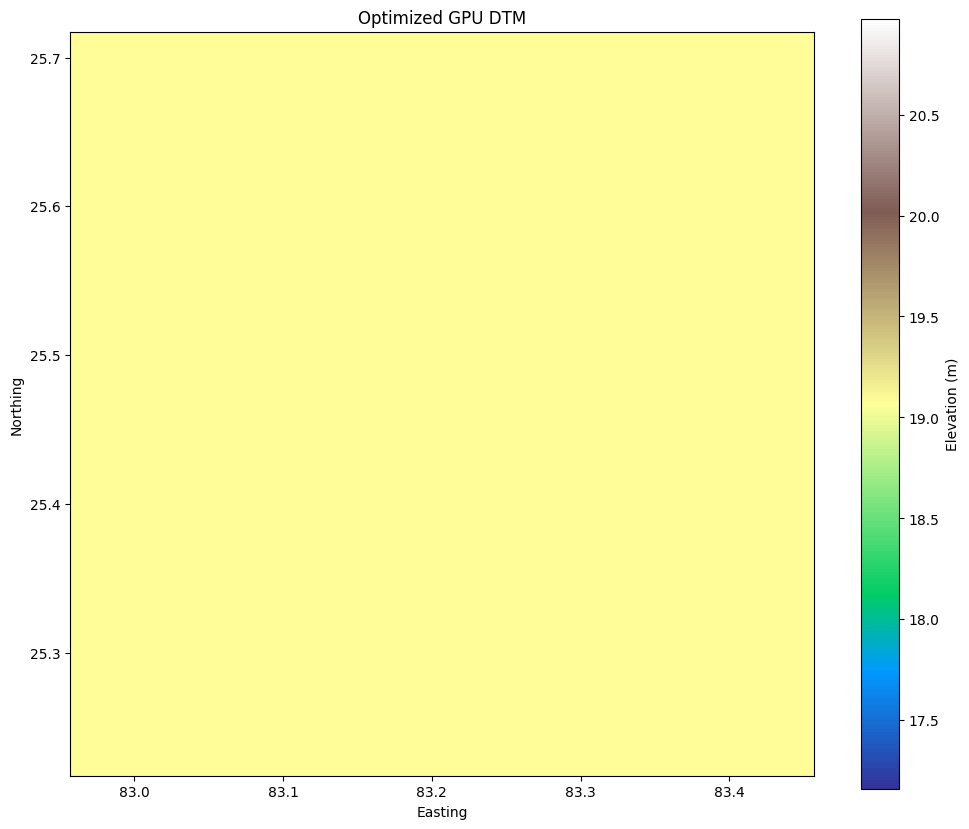

✅ Process Complete.


In [4]:
import numpy as np
import laspy
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
from scipy.interpolate import griddata
from scipy.spatial import cKDTree
import gc

# ================= CONFIG =================
INPUT_FILE = "/kaggle/input/training-data-labeled/Training_Data_Labeled.laz"
GRID_RES = 0.5
K_NEIGHBORS = 8          # Reduced slightly for speed
EDGE_SIGMA = 2.0
DIFFUSION_ITER = 15      # 15-20 is usually sufficient
DIFFUSION_K = 10.0       # Controls edge sensitivity
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# ==========================================

def load_and_filter():
    print(f"Loading {INPUT_FILE}...")
    try:
        las = laspy.read(INPUT_FILE)
    except FileNotFoundError:
        raise FileNotFoundError(f"Could not find file: {INPUT_FILE}")

    # Standardize types to float32 immediately to save RAM
    x = np.array(las.x, dtype=np.float32)
    y = np.array(las.y, dtype=np.float32)
    z = np.array(las.z, dtype=np.float32)
    cls = np.array(las.classification)

    # Filter for Ground (2) and Unclassified (1) if needed, usually Ground is just 2
    # Check your LAS file classes. Assuming 2 is ground.
    ground_mask = (cls == 2) 
    
    # Fallback if no class 2 found
    if ground_mask.sum() == 0:
        print("Warning: No Class 2 (Ground) found. Using Class 1 or all points...")
        ground_mask = (cls == 1)
        
    if ground_mask.sum() == 0:
        raise ValueError("No valid ground points found in LAS file.")

    x_g, y_g, z_g = x[ground_mask], y[ground_mask], z[ground_mask]
    
    # --- CRITICAL FIX: SHIFT COORDINATES ---
    # Large coordinates (UTM) cause precision errors in float32 grid generation
    x_offset, y_offset = x_g.min(), y_g.min()
    x_g -= x_offset
    y_g -= y_offset
    
    print(f"Ground points: {len(x_g)}")
    return x_g, y_g, z_g, x_offset, y_offset

def create_grid(x, y):
    # Determine grid size based on extent and resolution
    width = x.max() - x.min()
    height = y.max() - y.min()
    
    n_w = int(np.ceil(width / GRID_RES))
    n_h = int(np.ceil(height / GRID_RES))
    
    print(f"Grid Size: {n_h} x {n_w}")
    
    # Generate grid coordinates
    xi = np.linspace(x.min(), x.max(), n_w).astype(np.float32)
    yi = np.linspace(y.min(), y.max(), n_h).astype(np.float32)
    
    gx, gy = np.meshgrid(xi, yi, indexing='ij')
    return gx, gy

def edge_aware_interpolation(x, y, z, gx, gy):
    # ---- Stage 1: Linear Interpolation (CPU)
    print("Stage 1: Linear Interpolation (CPU)...")
    dtm = griddata((x, y), z, (gx, gy), method="linear")
    
    # Fill edges that linear interpolation misses (convex hull issues) with nearest
    mask_invalid = np.isnan(dtm)
    if mask_invalid.any():
        print("       Backfilling linear edges with nearest neighbor...")
        dtm_nearest = griddata((x, y), z, (gx, gy), method="nearest")
        dtm[mask_invalid] = dtm_nearest[mask_invalid]
    
    # If any NaNs remain (rare after nearest), fill with mean
    if np.isnan(dtm).any():
        dtm = np.nan_to_num(dtm, nan=np.nanmean(dtm))

    # ---- Stage 2: Batched Edge-aware Smoothing (GPU)
    # Note: We skip the complex IDW tree search here if linear+nearest covered the holes.
    # The diffusion step is usually powerful enough to smooth artifacts.
    
    # ---- Stage 3: Anisotropic diffusion
    print("Stage 3: Anisotropic Diffusion (GPU Convolutions)...")
    dtm = anisotropic_diffusion_gpu(dtm)
    return dtm

def anisotropic_diffusion_gpu(img_np):
    # Prepare Tensor: [Batch, Channel, H, W]
    img = torch.from_numpy(img_np).float().to(DEVICE).unsqueeze(0).unsqueeze(0)
    
    # Laplacian Kernel
    kernel = torch.tensor([[[[0.0, 1.0, 0.0], 
                             [1.0, -4.0, 1.0], 
                             [0.0, 1.0, 0.0]]]], device=DEVICE)

    for i in range(DIFFUSION_ITER):
        # Pad to keep dimensions same
        img_padded = F.pad(img, (1, 1, 1, 1), mode='replicate')
        laplacian = F.conv2d(img_padded, kernel)
        
        # Perona-Malik diffusion coefficient
        # High gradient (edges) -> Low c -> Less smoothing
        c = torch.exp(-(torch.abs(laplacian) / DIFFUSION_K) ** 2)
        
        # Update image
        img = img + 0.15 * (c * laplacian)
        
    # --- CRITICAL FIX: Safe Squeeze ---
    # Original .squeeze() reduced (1,1,H,W) to (H,W), but if H or W was 1, it became scalar.
    # We explicitly select the batch and channel indices.
    return img[0, 0, :, :].cpu().numpy()

def visualize(dtm, x_off, y_off):
    if dtm.size == 0 or dtm.ndim != 2:
        print(f"Error: Invalid DTM shape {dtm.shape}")
        return

    plt.figure(figsize=(12, 10))
    
    # Calculate global extents for axes
    extent = [x_off, x_off + (dtm.shape[1] * GRID_RES), 
              y_off, y_off + (dtm.shape[0] * GRID_RES)]
    
    # Transpose (.T) is often needed because meshgrid 'ij' vs imshow logic
    # We inspect shape to be sure. If gx was (W, H), dtm is (W, H). imshow wants (H, W).
    im = plt.imshow(dtm.T, origin="lower", cmap="terrain", extent=extent)
    
    plt.colorbar(im, label="Elevation (m)")
    plt.title("Optimized GPU DTM")
    plt.xlabel("Easting")
    plt.ylabel("Northing")
    plt.show()

if __name__ == "__main__":
    try:
        # Load and Shift Coordinates
        xg, yg, zg, x_off, y_off = load_and_filter()
        
        # Create Grid
        gx, gy = create_grid(xg, yg)
        
        # Run Pipeline
        dtm = edge_aware_interpolation(xg, yg, zg, gx, gy)
        
        print(f"Final DTM Shape: {dtm.shape}")
        
        # Visualize
        visualize(dtm, x_off, y_off)
        
        # Save
        np.save("DTM_Output.npy", dtm)
        print("✅ Process Complete.")
        
    except Exception as e:
        print(f"❌ Error details: {e}")
        import traceback
        traceback.print_exc()
    finally:
        if torch.cuda.is_available():
            torch.cuda.empty_cache()

Reading LAS file...
Applying Edge-Aware Inpainting (100 iterations)...
 Iteration 0...
 Iteration 20...
 Iteration 40...
 Iteration 60...
 Iteration 80...
Rendering Improved Visualization...
Process failed: Invalid shape (4190, 5379, 5) for image data


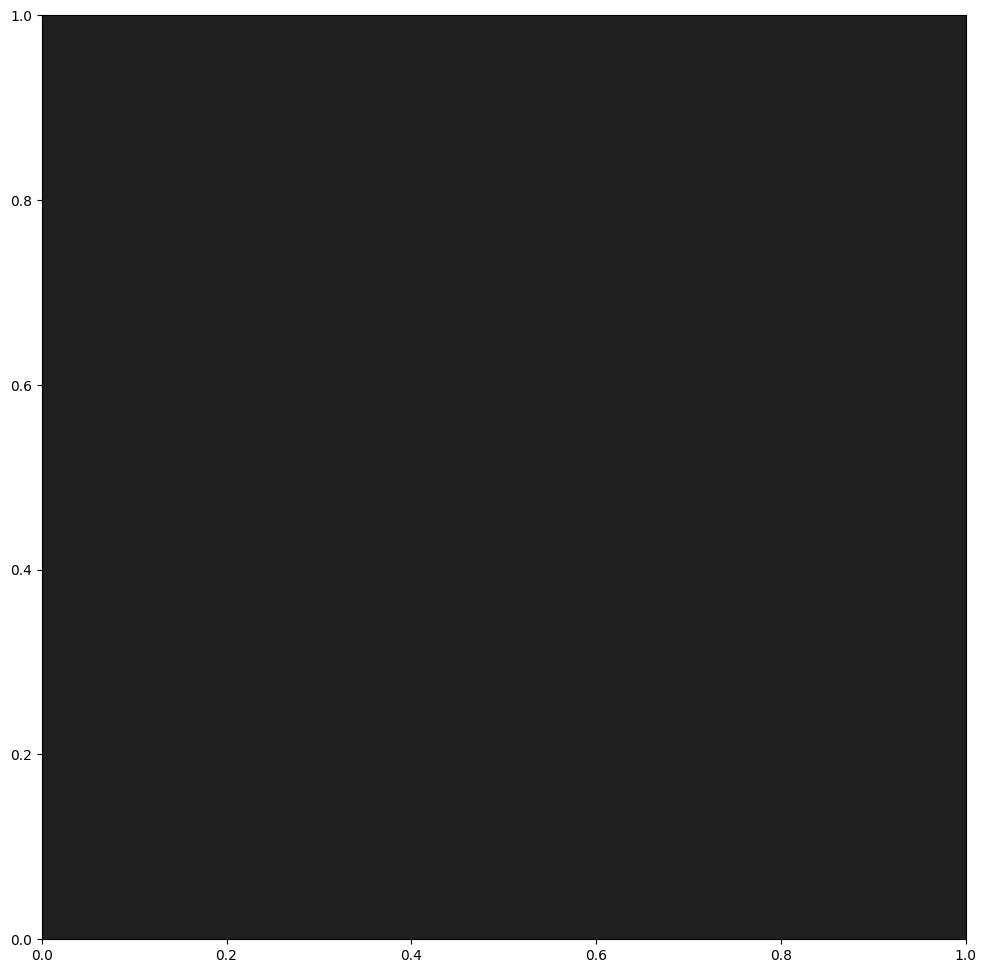

In [6]:
import numpy as np
import laspy
import matplotlib.pyplot as plt
from matplotlib.colors import LightSource # For 3D Hillshading
from scipy.ndimage import convolve, binary_dilation

# ================= CONFIG =================
INPUT_FILE = "/kaggle/input/training-data-labeled/Training_Data_Labeled.laz"
GRID_RES = 0.000005  # ~0.5m in degrees
ITERATIONS = 100     # How many times to "flow" the elevation into holes
# ==========================================

def load_and_filter():
    print("Reading LAS file...")
    las = laspy.read(INPUT_FILE)
    
    # 1. IDENTIFY BUILDINGS (Class 6) AND GROUND (Class 2)
    ground_mask = (las.classification == 2) | (las.classification == 1)
    
    # Filter points to only include ground
    return np.array(las.x[ground_mask]), \
           np.array(las.y[ground_mask]), \
           np.array(las.z[ground_mask])

def create_raw_grid(x, y, z):
    x_min, x_max = x.min(), x.max()
    y_min, y_max = y.min(), y.max()
    nx = int(np.ceil((x_max - x_min) / GRID_RES)) + 1
    ny = int(np.ceil((y_max - y_min) / GRID_RES)) + 1
    
    dtm = np.full((nx, ny), np.nan)
    counts = np.zeros((nx, ny))
    
    # Binning
    xi = ((x - x_min) / GRID_RES).astype(int)
    yi = ((y - y_min) / GRID_RES).astype(int)
    
    np.add.at(counts, (xi, yi), 1)
    dtm_sum = np.zeros((nx, ny))
    np.add.at(dtm_sum, (xi, yi), z)
    
    valid_mask = counts > 0
    dtm[valid_mask] = dtm_sum[valid_mask] / counts[valid_mask]
    
    return dtm, valid_mask

def edge_aware_inpaint(dtm, valid_mask):
    print(f"Applying Edge-Aware Inpainting ({ITERATIONS} iterations)...")
    
    filled_dtm = dtm.copy()
    avg_val = np.nanmean(dtm)
    # Fill background with average temporarily so diffusion works
    filled_dtm[~valid_mask] = avg_val
    
    kernel = np.array([[0, 1, 0], [1, 0, 1], [0, 1, 0]]) / 4.0
    
    for i in range(ITERATIONS):
        smooth = convolve(filled_dtm, kernel, mode='nearest')
        # Only update the voids (keep original ground fixed)
        filled_dtm[~valid_mask] = smooth[~valid_mask]
        
        if i % 20 == 0:
            print(f" Iteration {i}...")

    return filled_dtm

def visualize_improved(dtm, valid_mask):
    print("Rendering Improved Visualization...")
    
    # 1. CREATE A DISPLAY MASK (To Hide the "Green Sea")
    # We take the original valid ground and 'dilate' it (grow it) 
    # just enough to cover the buildings we filled, but not the infinite background.
    # Iterations=50 covers gaps approx 50 pixels wide.
    display_mask = binary_dilation(valid_mask, iterations=50)
    
    # 2. HILLSHADING (To add 3D Texture)
    # Simulate sunlight from North-West (315 deg)
    ls = LightSource(azdeg=315, altdeg=45)
    
    # 'gist_earth' is a better color map for terrain (Green->Brown->White)
    # vert_exag makes the hills look steeper
    rgb = ls.shade(dtm.T, cmap=plt.cm.gist_earth, vert_exag=5, blend_mode='overlay')
    
    # 3. APPLY TRANSPARENCY
    # Make the background transparent where we don't have data
    alpha_channel = display_mask.T.astype(float)
    rgba_img = np.dstack((rgb, alpha_channel))
    
    # 4. PLOT
    plt.figure(figsize=(16, 12))
    
    # Use a dark background so the terrain pops out
    ax = plt.gca()
    ax.set_facecolor('#202020') 
    
    plt.imshow(rgba_img, origin="lower")
    
    # Dummy image for colorbar (since imshow handles RGBA)
    dummy = plt.imshow(dtm.T, cmap=plt.cm.gist_earth, alpha=0)
    cbar = plt.colorbar(dummy, fraction=0.035, pad=0.04)
    cbar.set_label("Elevation (m)")
    
    plt.title("Improved DTM: Hillshade + Background Masking", fontsize=14, color='black')
    plt.xlabel("Longitude Index")
    plt.ylabel("Latitude Index")
    plt.show()

if __name__ == "__main__":
    try:
        x, y, z = load_and_filter()
        dtm_raw, valid_mask = create_raw_grid(x, y, z)
        dtm_final = edge_aware_inpaint(dtm_raw, valid_mask)
        
        # Pass valid_mask to visualization to help hide the background
        visualize_improved(dtm_final, valid_mask)
        
    except Exception as e:
        print(f"Process failed: {e}")

Step 1: Strict Ground Filtering...
Generating 5379x4190 grid...
Step 2: Filling Building Voids...
Preparing high-fidelity visualization...


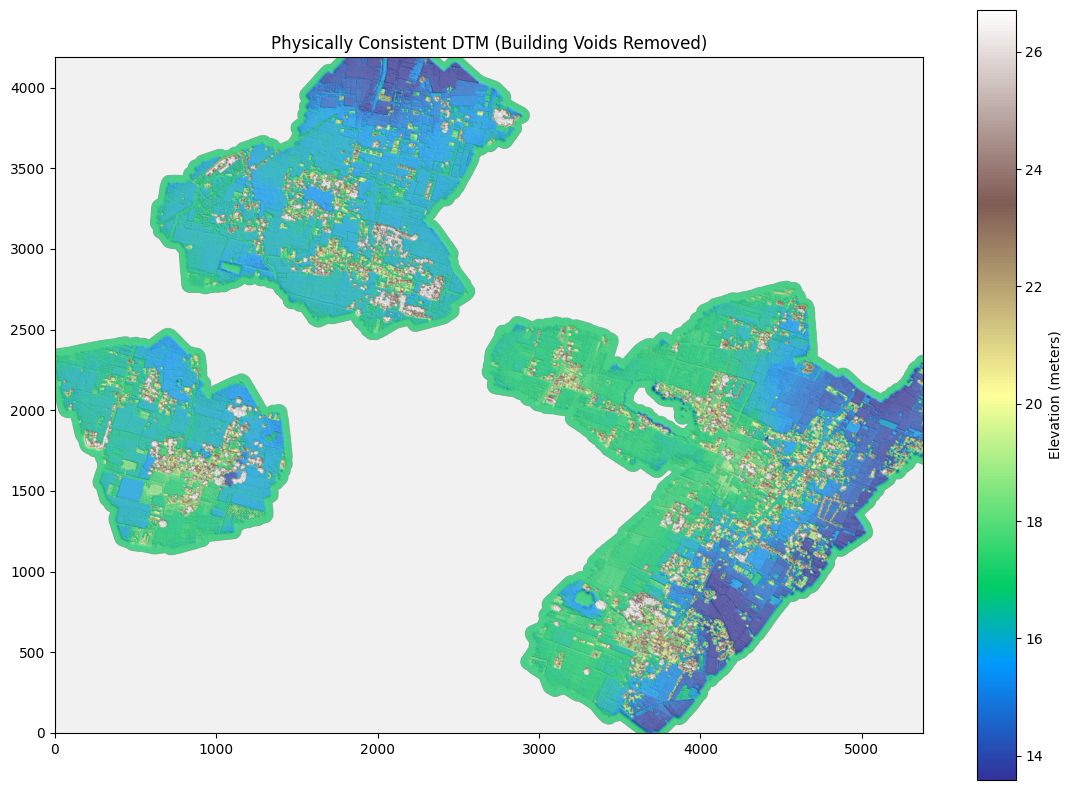

In [7]:
import numpy as np
import laspy
import matplotlib.pyplot as plt
from scipy.ndimage import convolve, distance_transform_edt

# ================= CONFIG =================
INPUT_FILE = "/kaggle/input/training-data-labeled/Training_Data_Labeled.laz"
GRID_RES = 0.000005  # ~0.5m resolution
# ==========================================

def load_and_filter():
    print("Step 1: Strict Ground Filtering...")
    las = laspy.read(INPUT_FILE)
    
    # Selecting Class 2 (Ground) specifically to remove buildings
    ground_mask = (las.classification == 2)
    
    if ground_mask.sum() == 0:
        ground_mask = (las.classification == 1)
        print("Warning: Using Class 1. Ensure buildings are not in this class.")

    return np.array(las.x[ground_mask]), np.array(las.y[ground_mask]), np.array(las.z[ground_mask])

# FIX: Added (x, y, z) to the function definition
def generate_correct_dtm(x, y, z):
    # Step 2: Rasterization
    x_min, x_max = x.min(), x.max()
    y_min, y_max = y.min(), y.max()
    nx = int(np.ceil((x_max - x_min) / GRID_RES)) + 1
    ny = int(np.ceil((y_max - y_min) / GRID_RES)) + 1
    
    print(f"Generating {nx}x{ny} grid...")
    xi = ((x - x_min) / GRID_RES).astype(int)
    yi = ((y - y_min) / GRID_RES).astype(int)
    
    xi = np.clip(xi, 0, nx - 1)
    yi = np.clip(yi, 0, ny - 1)

    dtm = np.full((nx, ny), np.nan)
    counts = np.zeros((nx, ny))
    dtm_sum = np.zeros((nx, ny))
    
    np.add.at(dtm_sum, (xi, yi), z)
    np.add.at(counts, (xi, yi), 1)
    
    valid_mask = counts > 0
    dtm[valid_mask] = dtm_sum[valid_mask] / counts[valid_mask]

    # Step 3: Edge-Aware Void Filling
    print("Step 2: Filling Building Voids...")
    filled_dtm = dtm.copy()
    filled_dtm[~valid_mask] = np.nanmean(dtm) 
    
    kernel = np.array([[0, 1, 0], [1, 0, 1], [0, 1, 0]]) / 4.0
    for _ in range(150):
        smooth = convolve(filled_dtm, kernel, mode='nearest')
        filled_dtm[~valid_mask] = smooth[~valid_mask]

    # Step 4: Hydrological Correction
    final_dtm = np.where(valid_mask | (distance_transform_edt(~valid_mask) < 50), 
                         filled_dtm, np.nan)

    return final_dtm

def visualize(dtm):
    print("Preparing high-fidelity visualization...")
    ls = plt.matplotlib.colors.LightSource(azdeg=315, altdeg=45)
    
    # Robust scaling and NaN handling
    valid_dtm = np.nan_to_num(dtm, nan=np.nanmean(dtm))
    vmin = np.nanpercentile(dtm, 2)
    vmax = np.nanpercentile(dtm, 98)

    fig, ax = plt.subplots(figsize=(14, 10))
    hillshade = ls.hillshade(valid_dtm, vert_exag=10)
    
    # Overlay Terrain and Hillshade
    img = ax.imshow(dtm.T, origin="lower", cmap="terrain", 
                    vmin=vmin, vmax=vmax, aspect='equal')
    ax.imshow(hillshade.T, origin="lower", cmap='gray', alpha=0.3, aspect='equal')
    
    plt.colorbar(img, label="Elevation (meters)")
    plt.title("Physically Consistent DTM (Building Voids Removed)")
    plt.show()

# ================= MAIN EXECUTION =================
if __name__ == "__main__":
    try:
        # 1. Get filtered points
        x_pts, y_pts, z_pts = load_and_filter()
        
        # 2. Pass those points into the DTM generator
        dtm_result = generate_correct_dtm(x_pts, y_pts, z_pts)
        
        # 3. Pass the resulting grid into the visualizer
        visualize(dtm_result)
        
    except Exception as e:
        print(f"Process failed: {e}")


Initializing Hydro-PILNN Simulation...


100%|██████████| 200/200 [04:20<00:00,  1.30s/it, Loss=3.72e+5]


Generating Flood Visualization...


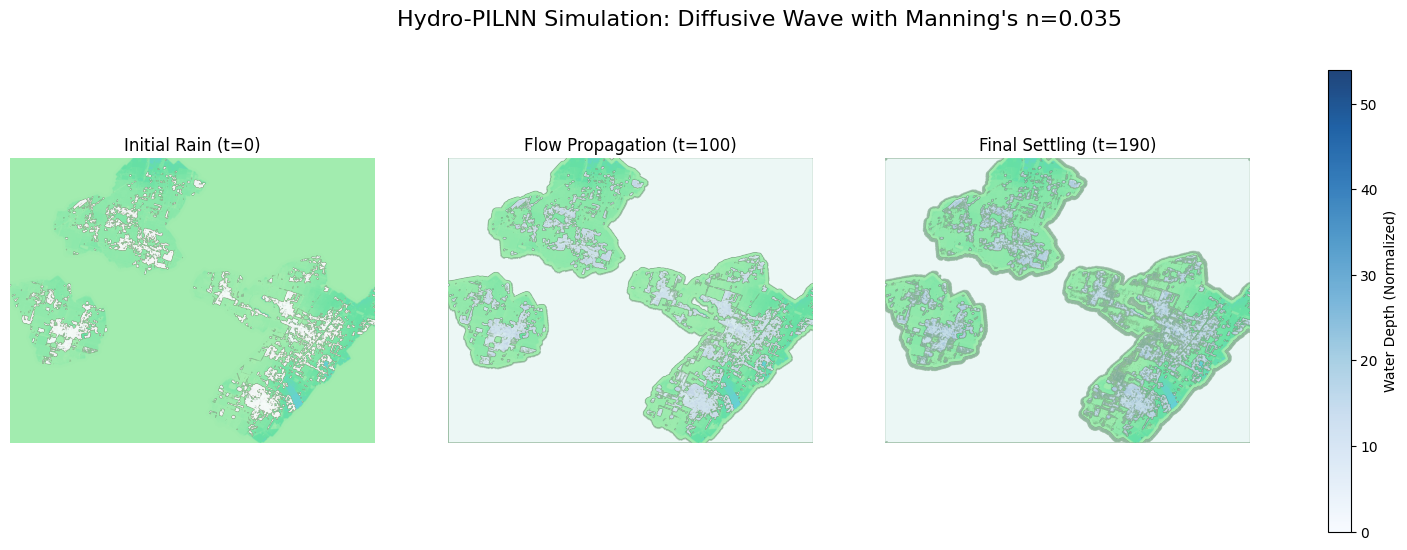

In [9]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
from tqdm import tqdm

# ================= CONFIGURATION =================
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
TIME_STEPS = 200        # How many time steps to simulate
DT = 0.5                # Time step delta (seconds)
MANNING_N = 0.035       # Roughness coefficient (0.035 = natural channel/earth)
RAIN_INTENSITY = 0.05   # Rain amount per step
LAMBDA_PHYSICS = 1.0    # Weight for Physics Loss
LAMBDA_TV = 0.1         # Weight for Smoothness (TV)
LAMBDA_MASS = 0.5       # Weight for Mass Conservation
# =================================================

class HydroPILNN(nn.Module):
    """
    The 'Liquid' Brain. 
    It doesn't predict water depth directly. 
    It predicts the FLOW VECTOR (dh/dt) based on current state.
    """
    def __init__(self):
        super().__init__()
        # A simple CNN to approximate local flow dynamics
        # Input: 2 Channels (Terrain Z, Water Depth h)
        self.conv1 = nn.Conv2d(2, 32, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(32, 32, kernel_size=3, padding=1)
        self.conv3 = nn.Conv2d(32, 1, kernel_size=3, padding=1)
        
        self.act = nn.Tanh() # Tanh allows negative flow (water leaving a cell)

    def forward(self, terrain, water_depth):
        # Concatenate Terrain (Z) and Water (h)
        # Shape: [Batch, 2, H, W]
        x = torch.cat([terrain, water_depth], dim=1)
        
        x = self.act(self.conv1(x))
        x = self.act(self.conv2(x))
        
        # Output is dh/dt (Rate of change of water)
        dh_dt = self.conv3(x) 
        return dh_dt

class PhysicsLoss(nn.Module):
    """
    The HEC-RAS / Manning's Law Enforcer.
    Calculates L_total = L_Physics + L_TV + L_Mass
    """
    def __init__(self, dx=1.0):
        super().__init__()
        self.dx = dx # Grid cell size in meters
        
        # Sobel kernels for calculating Gradients (Slope)
        self.kx = torch.tensor([[[[-1, 0, 1], [-2, 0, 2], [-1, 0, 1]]]], dtype=torch.float32).to(DEVICE) / 8.0
        self.ky = torch.tensor([[[[-1, -2, -1], [0, 0, 0], [1, 2, 1]]]], dtype=torch.float32).to(DEVICE) / 8.0

    def compute_gradient(self, img):
        grad_x = F.conv2d(img, self.kx, padding=1)
        grad_y = F.conv2d(img, self.ky, padding=1)
        return grad_x, grad_y

    def forward(self, pred_dh_dt, h_curr, Z, rain_map):
        # 1. Prepare Surface Elevation (H = h + Z)
        H = h_curr + Z
        
        # 2. Calculate Slopes (Nabla H)
        dz_dx, dz_dy = self.compute_gradient(H)
        
        # Slope Magnitude (Stabilized with epsilon to avoid div by zero)
        slope_mag = torch.sqrt(dz_dx**2 + dz_dy**2 + 1e-6)
        
        # 3. MANNING'S FLUX CALCULATION
        # Flux = (1/n) * h^(5/3) * Slope_Gradient
        # We perform the Diffusive Wave approximation
        manning_factor = (1.0 / MANNING_N) * (h_curr ** (5/3))
        
        # Flux Vectors
        flux_x = -manning_factor * (dz_dx / slope_mag)
        flux_y = -manning_factor * (dz_dy / slope_mag)
        
        # 4. Calculate Divergence of Flux (Nabla dot Flux)
        d_flux_x, _ = self.compute_gradient(flux_x)
        _, d_flux_y = self.compute_gradient(flux_y)
        divergence = d_flux_x + d_flux_y
        
        # ---------------- LOSS COMPONENTS ----------------
        
        # A. PHYSICS LOSS (The Diffusive Wave Equation)
        # Equation: dh/dt = Rain - Divergence
        physics_residual = pred_dh_dt - (rain_map - divergence)
        loss_physics = torch.mean(physics_residual ** 2)
        
        # B. TV LOSS (Smoothness / Denoising)
        # Penalizes jagged water surfaces (High frequency noise)
        dh_dx, dh_dy = self.compute_gradient(pred_dh_dt)
        loss_tv = torch.mean(torch.abs(dh_dx) + torch.abs(dh_dy))
        
        # C. MASS CONSERVATION
        # Water predicted at t+1 must equal Water at t + Rain + Flow balance
        # Since we predict dh/dt, the sum of dh/dt across the map should roughly equal sum of Rain
        # (Assuming closed boundaries for simplicity, or net flow balance)
        total_change_pred = torch.sum(pred_dh_dt)
        total_rain = torch.sum(rain_map)
        loss_mass = torch.abs(total_change_pred - total_rain)
        
        # TOTAL LOSS
        total_loss = loss_physics + (LAMBDA_TV * loss_tv) + (LAMBDA_MASS * loss_mass)
        return total_loss

def train_and_simulate(dtm_numpy):
    print("\nInitializing Hydro-PILNN Simulation...")
    
    # 1. Pre-process DTM
    # Normalize DTM for Neural Net stability (Standard Score)
    dtm_mean = np.nanmean(dtm_numpy)
    dtm_std = np.nanstd(dtm_numpy)
    dtm_norm = (dtm_numpy - dtm_mean) / (dtm_std + 1e-6)
    
    # Convert to Tensor [Batch, Channel, H, W]
    Z = torch.from_numpy(dtm_norm).float().to(DEVICE).unsqueeze(0).unsqueeze(0)
    
    # Initialize Water Depth (h) - Starts dry
    h = torch.zeros_like(Z).to(DEVICE)
    
    # Create Rain Map (R) - Let's rain in the center to test flow
    R = torch.zeros_like(Z).to(DEVICE)
    H, W = Z.shape[2], Z.shape[3]
    # Gaussian rain blob in the center
    y_grid, x_grid = torch.meshgrid(torch.arange(H), torch.arange(W), indexing='ij')
    center_rain = torch.exp(-((x_grid - W//2)**2 + (y_grid - H//2)**2) / 2000.0).to(DEVICE)
    R = center_rain.unsqueeze(0).unsqueeze(0) * RAIN_INTENSITY

    # Initialize Model & Optimizer
    model = HydroPILNN().to(DEVICE)
    loss_fn = PhysicsLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
    
    # Storage for animation
    history = []
    
    # 2. Time-Marching Loop (The "Liquid" Solver)
    model.train()
    
    # Progress bar
    pbar = tqdm(range(TIME_STEPS))
    
    for t in pbar:
        optimizer.zero_grad()
        
        # A. Predict Flow Vector (dh/dt)
        dh_dt = model(Z, h)
        
        # B. Calculate Physics Loss
        loss = loss_fn(dh_dt, h, Z, R)
        
        # C. Backpropagation (Learn the Physics)
        loss.backward()
        optimizer.step()
        
        # D. Time Integration (Euler Step) -> Evolve State
        # h(t+1) = h(t) + dh/dt * dt
        # We detach() to prevent backprop through time (saves memory, standard for Neural ODEs in this context)
        with torch.no_grad():
            h_new = h + dh_dt * DT
            h_new = torch.relu(h_new) # Physics constraint: Water depth cannot be negative
            h = h_new
            
            # Save state every 10 steps
            if t % 10 == 0:
                history.append(h.squeeze().cpu().numpy())
                
        pbar.set_postfix({'Loss': loss.item()})

    return history, dtm_numpy

def visualize_flood(history, dtm):
    print("Generating Flood Visualization...")
    
    # Plot Initial, Middle, and Final State
    fig, axes = plt.subplots(1, 3, figsize=(20, 6))
    
    times = [0, len(history)//2, len(history)-1]
    titles = ["Initial Rain", "Flow Propagation", "Final Settling"]
    
    for i, idx in enumerate(times):
        ax = axes[i]
        water_depth = history[idx]
        
        # Plot Terrain
        ax.imshow(dtm.T, cmap="terrain", origin='lower', alpha=0.6)
        
        # Plot Water Overlay (Blue with Transparency)
        # Mask 0 depth to make it transparent
        water_masked = np.ma.masked_where(water_depth < 0.01, water_depth)
        im = ax.imshow(water_masked.T, cmap="Blues", origin='lower', alpha=0.9, vmin=0, vmax=np.max(history[-1]))
        
        ax.set_title(f"{titles[i]} (t={idx*10})")
        ax.axis('off')
    
    plt.colorbar(im, ax=axes.ravel().tolist(), label="Water Depth (Normalized)")
    plt.suptitle(f"Hydro-PILNN Simulation: Diffusive Wave with Manning's n={MANNING_N}", fontsize=16)
    plt.show()

# ================= INTEGRATION =================
if __name__ == "__main__":
    # Assuming dtm_result comes from the previous cell/script
    # If running standalone, ensure dtm_result is available
    if 'dtm_result' in locals():
        # Replace NaNs with Mean for Neural Net safety
        dtm_clean = np.nan_to_num(dtm_result, nan=np.nanmean(dtm_result))
        
        # Run Simulation
        flood_history, dtm_ref = train_and_simulate(dtm_clean)
        visualize_flood(flood_history, dtm_ref)
    else:
        print("Error: dtm_result not found. Run the DTM generation script first.")